# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pd.options.display.max_rows = None
pd.options.display.max_columns = None

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [4]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [7]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_ERL,person,ordinal,[-1]
freq,1,43,49,26


In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
total_col = azdias.shape[1]
count = 0

for column in range(azdias.shape[1]):
    column_name=azdias.columns[column]
    nan_list = feat_info.iloc[column,3].replace('[','').replace(']','')
    count += 1
    if nan_list =='':
        continue
    else:
        nan_list = nan_list.split(',')
        for nan_code in nan_list:
            if azdias[column_name].dtype != 'object':
                nan_code = int(nan_code)
            azdias.loc[azdias[column_name] == nan_code, column_name] = np.nan
        # Display progress (so I know it is still running)
        clear_output(wait=True)
        display(str(count)+"/"+str(total_col)+" Columns processed")

'85/85 Columns processed'

In [10]:
#Checking I see some NaNs
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,NaN,2.0,5.0,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,NaN,1.0,5.0,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,NaN,1.0,3.0,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,NaN,2.0,4.0,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_column = azdias.isnull().sum()

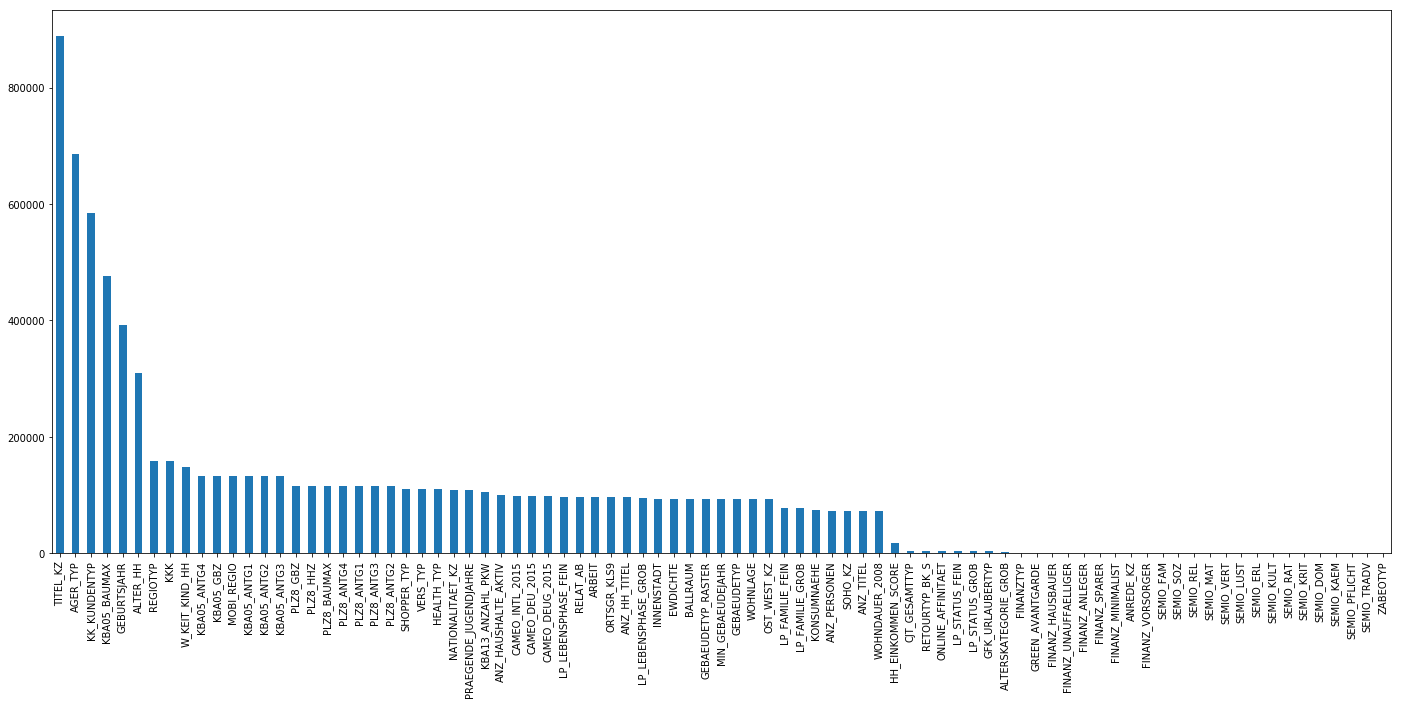

In [12]:
# Investigate patterns in the amount of missing data in each column.
missing_column.sort_values(ascending=False).plot(kind='bar', figsize=(24, 10));

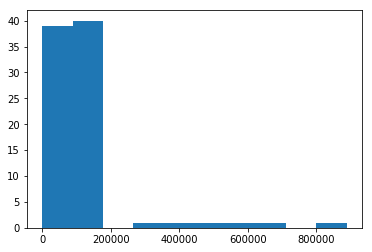

In [13]:
plt.hist(missing_column);

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
nan_count = missing_column[missing_column>200000]
azdias = azdias.drop(nan_count.index, axis = 1)

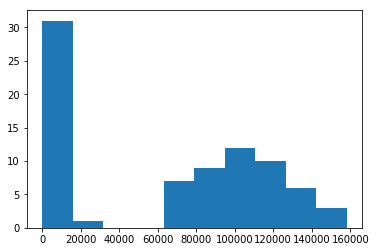

In [15]:
plt.hist(azdias.isnull().sum());

In [146]:
# Verifying no columns with over 200k missing fields 
azdias.isnull().sum().sort_values(ascending=False).nlargest(15)

KKK               158064
REGIOTYP          158064
W_KEIT_KIND_HH    147988
MOBI_REGIO        133324
KBA05_ANTG4       133324
KBA05_ANTG3       133324
KBA05_ANTG2       133324
KBA05_ANTG1       133324
KBA05_GBZ         133324
PLZ8_ANTG2        116515
PLZ8_ANTG1        116515
PLZ8_ANTG3        116515
PLZ8_ANTG4        116515
PLZ8_BAUMAX       116515
PLZ8_HHZ          116515
dtype: int64

In [17]:
# Exploring the remaining missing values and tiers
tiers = azdias.isnull().sum().sort_values(ascending=False)
print("# columns with more than 73,000 missing values ", tiers[tiers>73000].count(), 
      "\n# columns with less than 20,000 missing values ", tiers[tiers<20000].count())

# columns with more than 73,000 missing values  47 
# columns with less than 20,000 missing values  32


In [18]:
# Checking the duplication of missing data amounts
duplicates = tiers[tiers.duplicated(keep = 'first')]
duplicates[duplicates > 0]

REGIOTYP             158064
KBA05_ANTG4          133324
KBA05_ANTG3          133324
KBA05_ANTG2          133324
KBA05_ANTG1          133324
KBA05_GBZ            133324
PLZ8_ANTG1           116515
PLZ8_ANTG3           116515
PLZ8_ANTG4           116515
PLZ8_BAUMAX          116515
PLZ8_HHZ             116515
PLZ8_GBZ             116515
SHOPPER_TYP          111196
VERS_TYP             111196
CAMEO_DEU_2015        99352
CAMEO_DEUG_2015       99352
ARBEIT                97375
BALLRAUM              93740
EWDICHTE              93740
MIN_GEBAEUDEJAHR      93148
WOHNLAGE              93148
GEBAEUDETYP           93148
LP_FAMILIE_GROB       77792
ANZ_TITEL             73499
WOHNDAUER_2008        73499
SOHO_KZ               73499
GFK_URLAUBERTYP        4854
RETOURTYP_BK_S         4854
ONLINE_AFFINITAET      4854
LP_STATUS_FEIN         4854
LP_STATUS_GROB         4854
dtype: int64

#### Discussion 1.1.2: Assess Missing Data in Each Column

There are three tiers of missing data.  Six columns standout with over 200,000 rows of missing data. After that 47 columns have between 73,499 and 158,064 rows missing and 32 columns have less than 20,000 rows of missing data.

The six columns that are over 200,000 rows of missing are so disproportionately more than the remaining 79 that they are being removed. The removed columns were:
- TITEL_KZ
- AGER_TYP
- KK_KUNDENTYP
- KBA05_BAUMAX
- GEBURTSJAHR
- ALTER_HH

Of the remaining data there are trends of missing values in similar data columns. 
- KBA05_ANTG 1-4 are number of microcells  in different sized family homes and all have 133,324 missing values. 
- PLZ8_ANTG 1-4, PLZ8_BAUMAX, PLZ8_HHZ, and PLZ8_GBZ are number of houses or buildings in that region and all have 116,515 missing values.
- CAMEO_DEUG_2015, CAMEO_EU_2015, AND CAMEO_INTL_2015 are all about wealth/life stage and have 99,352 missing values
-

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

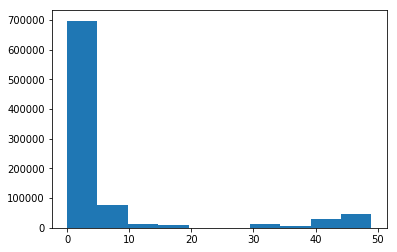

In [19]:
# How much data is missing in each row of the dataset?
missing_row = azdias.isnull().sum(axis = 1)
plt.hist(missing_row);

In [147]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
group_1 = missing_row[missing_row < 25]
group_2 = missing_row[missing_row >= 25]

azdias_1 = azdias.iloc[group_1.index,:]
azdias_2 = azdias.iloc[group_2.index,:]

print("Confirm that no rows were lost:" 
      "\nOriginal: ", azdias.shape[0], 
      "\nSubset 1 (less than 25 missing values): ", azdias_1.shape[0], 
      "\nSubset 2 (more than 25 missing values): ", azdias_2.shape[0], 
      "\nSubsets Total: ", azdias_1.shape[0]+azdias_2.shape[0])

Confirm that no rows were lost:
Original:  891221 
Subset 1 (less than 25 missing values):  797906 
Subset 2 (more than 25 missing values):  93315 
Subsets Total:  891221


In [21]:
tiers[tiers < 30000]

HH_EINKOMMEN_SCORE       18348
CJT_GESAMTTYP             4854
GFK_URLAUBERTYP           4854
RETOURTYP_BK_S            4854
ONLINE_AFFINITAET         4854
LP_STATUS_FEIN            4854
LP_STATUS_GROB            4854
ALTERSKATEGORIE_GROB      2881
SEMIO_FAM                    0
SEMIO_SOZ                    0
ANREDE_KZ                    0
SEMIO_TRADV                  0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
FINANZTYP                    0
SEMIO_PFLICHT                0
GREEN_AVANTGARDE             0
SEMIO_KAEM                   0
SEMIO_DOM                    0
SEMIO_KRIT                   0
SEMIO_RAT                    0
SEMIO_KULT                   0
SEMIO_ERL                    0
SEMIO_LUST                   0
SEMIO_VERT                   0
SEMIO_MAT                    0
SEMIO_REL                    0
ZABEOTYP                     0
dtype: i

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


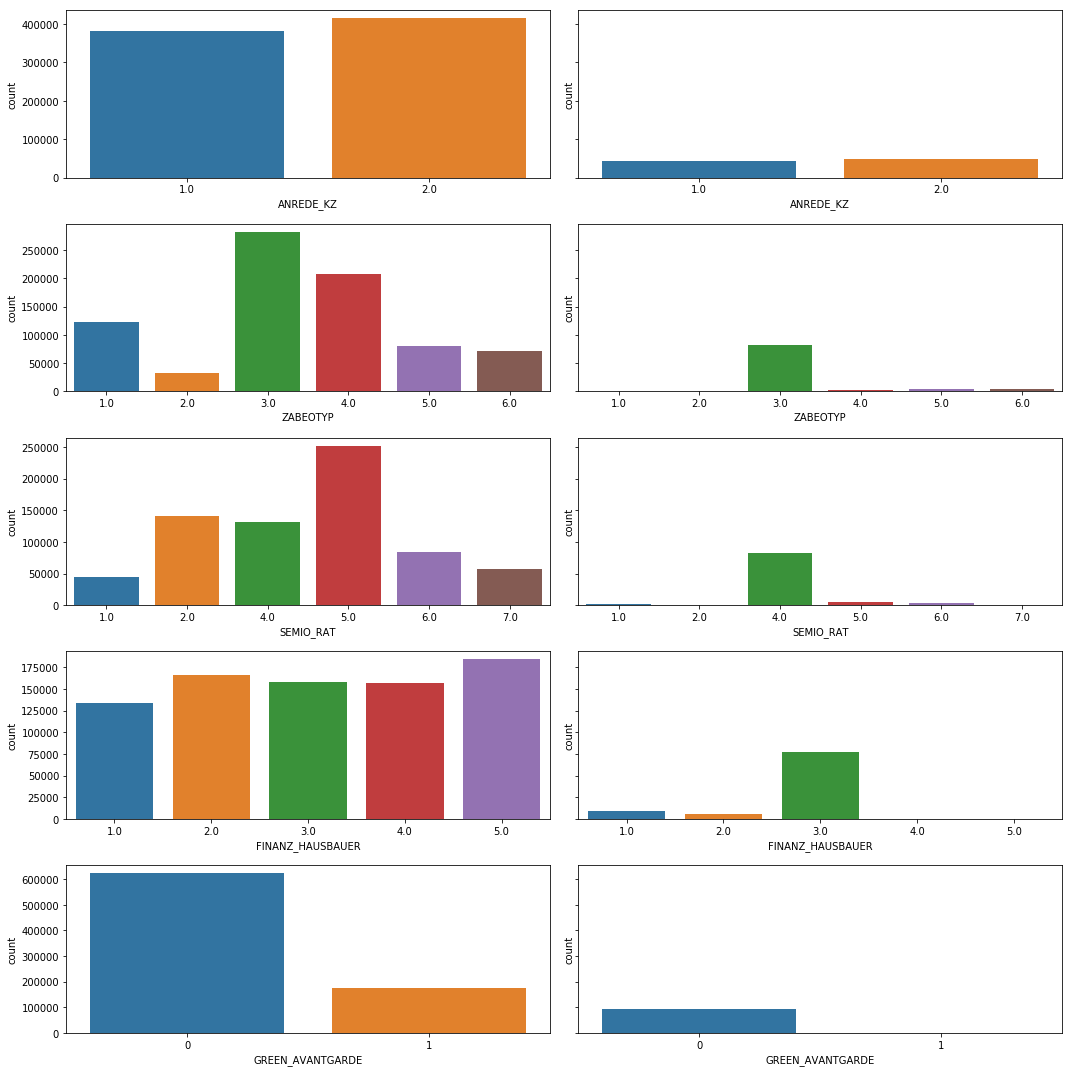

In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
fig, ((ax1, ax2),
      (ax3, ax4),
     (ax5, ax6),
     (ax7, ax8),
     (ax9, ax10)) = plt.subplots(5,2, sharex = 'row', sharey = 'row', figsize=(15,15))
sns.countplot(x='ANREDE_KZ', data= azdias_1, ax = ax1)
sns.countplot(x='ANREDE_KZ', data= azdias_2, ax = ax2)
sns.countplot(x='ZABEOTYP', data= azdias_1, ax = ax3)
sns.countplot(x='ZABEOTYP', data= azdias_2, ax = ax4)
sns.countplot(x='SEMIO_RAT', data= azdias_1, ax = ax5)
sns.countplot(x='SEMIO_RAT', data= azdias_2, ax = ax6)
sns.countplot(x='FINANZ_HAUSBAUER', data= azdias_1, ax = ax7)
sns.countplot(x='FINANZ_HAUSBAUER', data= azdias_2, ax = ax8)
sns.countplot(x='GREEN_AVANTGARDE', data= azdias_1, ax = ax9)
sns.countplot(x='GREEN_AVANTGARDE', data= azdias_2, ax = ax10)

fig.tight_layout()
fig.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

For the column's checked with no missing data fields, rows with low amounts of missing data (less than 25 cells) had a similar response breakdowns in some columns as those with lots of missing data (more than 25 cells), but others had very different patterns. 

There was a similar pattern with ANREDE_KZ (gender), GREEN_AVANTGARDE (Member in environmental sustainability as a youth), and ZABEOTYP(type of energy consumption).  

Both SEMIO_RAT (Personality type: rational) and FINANZ_HAUSBAUER (financial type: home ownership) had different patterns and majority responses to the data.  For FFINANZ_HAUSBAUER average ownership stands out in the higher missing data group, whereas all fields are within 50,000 of each other in the the lower missing data group.  For SEMIO_RAT there is a normal distribution in the lower data group, with low affinity standing out, in the higher missing data group average affinity stands out with others barely registering.  

Because some of these fields were so different, and the rows with higher amounts of data missing is only 10% of the dataset I will opt to remove those rows.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
# How many features are there of each data type?
feat_info.groupby(['type'])['attribute'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_fields = feat_info[feat_info['type']=='categorical']
cat_list = []
for column in range(azdias_1.shape[1]):
    column_name=azdias_1.columns[column]
    for cat in cat_fields['attribute']:
        if column_name == cat:
            print(azdias_1[column_name].value_counts())
            cat_list.append(column_name)

2.0    416089
1.0    381817
Name: ANREDE_KZ, dtype: int64
4.0    198280
3.0    147203
2.0    141260
5.0    111104
6.0    102075
1.0     93306
Name: CJT_GESAMTTYP, dtype: int64
6.0    289047
1.0    197117
5.0    106321
2.0    104748
4.0     55916
3.0     44757
Name: FINANZTYP, dtype: int64
12.0    130235
10.0    102823
8.0      83028
11.0     75099
5.0      70498
4.0      60422
9.0      57124
3.0      53101
1.0      50656
2.0      43826
7.0      40678
6.0      25738
Name: GFK_URLAUBERTYP, dtype: int64
0    622698
1    175208
Name: GREEN_AVANTGARDE, dtype: int64
1.0     402538
10.0    128966
2.0      98548
11.0     48744
8.0      21780
7.0      19575
4.0      11574
5.0      11167
9.0      10452
6.0       8526
3.0       4688
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    402538
5.0    188162
2.0     98548
4.0     49881
3.0     27429
Name: LP_FAMILIE_GROB, dtype: int64
1.0     206852
9.0     136344
10.0    111573
2.0     111100
4.0      73969
3.0      68917
6.0      28894
5.0      27582
8.0   

In [25]:
# What Categories to drop and remove from the list of categorical value columns
azdias_1 = azdias_1.drop('GFK_URLAUBERTYP', axis = 1)
cat_list.remove('GFK_URLAUBERTYP');
azdias_1 = azdias_1.drop('LP_FAMILIE_FEIN', axis = 1)
cat_list.remove('LP_FAMILIE_FEIN');
azdias_1 = azdias_1.drop('LP_STATUS_FEIN', axis = 1)
cat_list.remove('LP_STATUS_FEIN');
azdias_1 = azdias_1.drop('NATIONALITAET_KZ', axis = 1)
cat_list.remove('NATIONALITAET_KZ');
azdias_1 = azdias_1.drop('SOHO_KZ', axis = 1)
cat_list.remove('SOHO_KZ');
azdias_1 = azdias_1.drop('CAMEO_DEU_2015', axis = 1)
cat_list.remove('CAMEO_DEU_2015');

In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_1 = pd.get_dummies(azdias_1,columns = cat_list)

In [27]:
# Verify one hot encoding worked.
azdias_1.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ_1.0,ANREDE_KZ_2.0,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,21.0,6.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,NaN,NaN,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,32.0,10.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
5,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,8.0,2.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [28]:
# Checkpoint save
azdias_1.to_csv('azdias_na2.csv')

#### Discussion 1.2.1: Re-Encode Categorical Features

There are 21 categorical fields to to determine what to keep. After each was reviewed and adjusted as needed, get_dummies was used to convert categories into binary.
- ANREDE_KZ - While there were four possible answers, all data responded male or female.  I kept this field as it is binary and could be important.
- CJT_GESAMTTYP - Consumer buying channels with six fields, which I kept as how buyers are targeted seems relavent.
- FINANZTYP - Financial type of individual, kept as could be useful for identifying public who are similar to existing customers.
- GFK_URLAUBERTYP - Vacation habits, this doesn't seem relevant to financial services so it was dropped.
- GREEN_AVANTGARDE - Binary field on if they were a member in environmental group as a youth.  Could show a trend in own sales and link to public, so keeping it.
- LP_FAMILIE_FEIN - Family format, dropped because while the added detail to family structure would be useful, it had significant different amount of data between types. Another field (LP_FAMILIE_GROB) is more basic fields and will be useful.
- LP_FAMILIE_GROB - Family format, more basic than previous and with larger data samples per group, so kept.
- LP_STATUS_FEIN - Social status with more detail, dropped because while potentially useful level of detail each classification has limited sample size.
- LP_STATUS_GROB - Social Status, less detail but decent sample per group so category is kept.
- NATIONALITAET_KZ - Nationality assumed based on given name.  Dropped as most (roughly 86%) are in the german sounding category, so likely not enough in other categories to be telling.
- SHOPPER_TYP - Shopping type - Kept as good spread between each category and could be good for identifying new customers.
- SOHO_KZ - Binary that they have a small/home office or not.  Dropped as less than 1% of data is in small/home office category.
- VERS_TYP - Insurance type, kept as answers are binary and a near even split.
- ZABEOTYP - Energy consumption mentality, category kept as it may tell about buyers mindframe and most categories have a decent percentage of the database.
- GEBAEUDETYP - Building type, kept.  While most categories have a small sample of the database, the primary mixed use and residential are higher percentage and category could be useful in identifying customers.
- OST_WEST_KZ - Whether building is in former east or west of Germany.  Field kept as could be telling and will converted to binary from letters.
- CAMEO_DEUG_2015 - Socio economic status, kept as all categories make up a decent percentage of the data.
- CAMEO_DEU_2015 - More detailed socioeconomic status, dropped as populations of each category get too small.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [29]:
# Checking what fields are mixed
feat_info[feat_info['type']=='mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [30]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_1['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    182964
8.0     141598
10.0     85793
5.0      84682
3.0      53840
15.0     42540
11.0     35746
9.0      33569
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5762
7.0       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [31]:
# Creating variable of whether the dominating movement of a persons youth was avantegarde or mainstream
azdias_1.loc[azdias_1['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]), 'WEATHER_MAINSTREAM']=0
azdias_1.loc[azdias_1['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]), 'WEATHER_MAINSTREAM']=1

#Verify nothing lost
print("Original number of rows: ", azdias_1['PRAEGENDE_JUGENDJAHRE'].value_counts().sum(), \
      "\nNew column number of rows", azdias_1['WEATHER_MAINSTREAM'].value_counts().sum())

Original number of rows:  769209 
New column number of rows 769209


In [32]:
# Creating variable of whether the dominating movement of a persons you was east, west, or both
azdias_1.loc[azdias_1['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]), 'REGION']=0
azdias_1.loc[azdias_1['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]), 'REGION']=1
azdias_1.loc[azdias_1['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]), 'REGION']=2

#Verify nothing lost
print("Original number of rows: ", azdias_1['PRAEGENDE_JUGENDJAHRE'].value_counts().sum(), \
      "\nNew column number of rows", azdias_1['REGION'].value_counts().sum())

Original number of rows:  769209 
New column number of rows 769209


In [33]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_1['CAMEO_INTL_2015'].value_counts()

51    133691
41     92336
24     91147
14     62880
43     56671
54     45390
25     39624
22     33149
23     26732
13     26332
45     26132
55     23954
52     20542
31     19012
34     18524
15     16974
44     14820
12     13245
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [34]:
azdias_1['CAMEO_INTL_2015'] = azdias_1['CAMEO_INTL_2015'].astype(float)

# Creating variable for HOUSEHOLD_WEALTH
azdias_1.loc[azdias_1['CAMEO_INTL_2015'].isin([51,52,53,54,55]), 'HOUSEHOLD_WEALTH']=0
azdias_1.loc[azdias_1['CAMEO_INTL_2015'].isin([41,42,43,44,45]), 'HOUSEHOLD_WEALTH']=1
azdias_1.loc[azdias_1['CAMEO_INTL_2015'].isin([31,32,33,34,35]), 'HOUSEHOLD_WEALTH']=2
azdias_1.loc[azdias_1['CAMEO_INTL_2015'].isin([21,22,23,24,25]), 'HOUSEHOLD_WEALTH']=3
azdias_1.loc[azdias_1['CAMEO_INTL_2015'].isin([11,12,13,14,15]), 'HOUSEHOLD_WEALTH']=4

print("Original number of rows: ", azdias_1['CAMEO_INTL_2015'].value_counts().sum(), \
      "\nNew column number of rows", azdias_1['HOUSEHOLD_WEALTH'].value_counts().sum())

Original number of rows:  791800 
New column number of rows 791800


In [35]:
# Creating variable for HOUSEHOLD_LIFE_STAGE
azdias_1.loc[azdias_1['CAMEO_INTL_2015'].isin([11,21,31,41,51]), 'HOUSEHOLD_LIFE_STAGE']=0
azdias_1.loc[azdias_1['CAMEO_INTL_2015'].isin([12,22,32,42,52]), 'HOUSEHOLD_LIFE_STAGE']=1
azdias_1.loc[azdias_1['CAMEO_INTL_2015'].isin([13,23,33,43,53]), 'HOUSEHOLD_LIFE_STAGE']=2
azdias_1.loc[azdias_1['CAMEO_INTL_2015'].isin([14,24,34,44,54]), 'HOUSEHOLD_LIFE_STAGE']=3
azdias_1.loc[azdias_1['CAMEO_INTL_2015'].isin([15,25,35,45,55]), 'HOUSEHOLD_LIFE_STAGE']=4

print("Original number of rows: ", azdias_1['CAMEO_INTL_2015'].value_counts().sum(), \
      "\nNew column number of rows", azdias_1['HOUSEHOLD_LIFE_STAGE'].value_counts().sum())

Original number of rows:  791800 
New column number of rows 791800


In [36]:
# Investigate "WOHNLAGE" and engineer new variables.
azdias_1['WOHNLAGE'].value_counts()

3.0    249693
7.0    169304
4.0    135959
2.0    100364
5.0     74336
1.0     43913
8.0     17455
0.0      6882
Name: WOHNLAGE, dtype: int64

In [37]:
# Creating variable for whether they are RURAL
azdias_1.loc[azdias_1['WOHNLAGE'].isin([7,8]), 'RURAL']=0
azdias_1.loc[azdias_1['WOHNLAGE'].isin([0,1,2,3,4,5]), 'RURAL']=1

print("Original number of rows: ", azdias_1['WOHNLAGE'].value_counts().sum(), \
      "\nNew column number of rows", azdias_1['RURAL'].value_counts().sum())

Original number of rows:  797906 
New column number of rows 797906


In [38]:
# Investigate "PLZ8_BAUMAX" and engineer new variable.
azdias_1['PLZ8_BAUMAX'].value_counts()

1.0    499550
5.0     97333
2.0     70407
4.0     56684
3.0     50732
Name: PLZ8_BAUMAX, dtype: int64

In [39]:
# Creating variable for whether they are RESIDENTIAL
azdias_1.loc[azdias_1['PLZ8_BAUMAX'].isin([1,2,3,4]), 'RESIDENTIAL']=0
azdias_1.loc[azdias_1['PLZ8_BAUMAX'].isin([5]), 'RESIDENTIAL']=1

print("Original number of rows: ", azdias_1['PLZ8_BAUMAX'].value_counts().sum(), \
      "\nNew column number of rows", azdias_1['RESIDENTIAL'].value_counts().sum())

Original number of rows:  774706 
New column number of rows 774706


In [40]:
# Mixed category types to drop.
azdias_1 = azdias_1.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)
azdias_1 = azdias_1.drop('CAMEO_INTL_2015', axis = 1)
azdias_1 = azdias_1.drop('LP_LEBENSPHASE_FEIN', axis = 1)
azdias_1 = azdias_1.drop('LP_LEBENSPHASE_GROB', axis = 1)
azdias_1 = azdias_1.drop('WOHNLAGE', axis = 1)
azdias_1 = azdias_1.drop('PLZ8_BAUMAX', axis = 1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

The seven mixed types are LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, PRAEGENDE_JUGENDJAHRE, WOHNLAGE, CAMEO_INTL_2015, KBA05_BAUMAX, and PLZ8_BAUMAX.

PRAEGENDE_JUGENDJAHRE I split between whether the dominating movement of their youth was mainstream or avantegarde and also split by whether they were east, west, or a combination.

CAMEO_INTL_2015 I split by the household wealth groups and by the household life stage.

LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB I chose to drop as household wealth and life stage were covered in CAMEO_INTL_2015.

WOHNLAGE I chose to divide into whether or not they were rural.

KBA05_BAUMAX was already dropped due to the amount of missing data.

PLZ8_BAUMAX I chose to reengineer into whether or not they are mostly residential areas.

In [41]:
# Saving Checkpoint
azdias_1.to_csv('azdias_na3.csv')

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [42]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [43]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Confirming remaining columns are not low data
azdias_1.reindex_axis(sorted(azdias_1.columns),axis=1).info(max_cols = 150, memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797906 entries, 1 to 891220
Data columns (total 117 columns):
ALTERSKATEGORIE_GROB     795106 non-null float64
ANREDE_KZ_1.0            797906 non-null uint8
ANREDE_KZ_2.0            797906 non-null uint8
ANZ_HAUSHALTE_AKTIV      791486 non-null float64
ANZ_HH_TITEL             794089 non-null float64
ANZ_PERSONEN             797906 non-null float64
ANZ_TITEL                797906 non-null float64
ARBEIT                   793681 non-null float64
BALLRAUM                 797314 non-null float64
CAMEO_DEUG_2015_1        797906 non-null uint8
CAMEO_DEUG_2015_2        797906 non-null uint8
CAMEO_DEUG_2015_3        797906 non-null uint8
CAMEO_DEUG_2015_4        797906 non-null uint8
CAMEO_DEUG_2015_5        797906 non-null uint8
CAMEO_DEUG_2015_6        797906 non-null uint8
CAMEO_DEUG_2015_7        797906 non-null uint8
CAMEO_DEUG_2015_8        797906 non-null uint8
CAMEO_DEUG_2015_9        797906 non-null uint8
CJT_GESAMTTYP_1.0        797

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [44]:
def clean_data(df, cat_list):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs
    total_col = df.shape[1]
    count = 0

    for column in range(df.shape[1]):
        column_name = df.columns[column]
        nan_list = feat_info.iloc[column,3].replace('[','').replace(']','')
        count += 1
        if nan_list =='':
            continue
        else:
            nan_list = nan_list.split(',')
            for nan_code in nan_list:
                if df[column_name].dtype != 'object':
                    nan_code = int(nan_code)
                df.loc[df[column_name] == nan_code, column_name] = np.nan
            clear_output(wait=True)
            display(str(count)+"/"+str(total_col)+" Columns processed")
    
    # remove selected columns and rows
    df = df.drop(nan_count.index, axis = 1)
    
    missing_row = df.isnull().sum(axis = 1)
    group_1 = missing_row[missing_row < 25]
    group_2 = missing_row[missing_row > 25]
    df = df.iloc[group_1.index,:]
    
    df = df.drop('GFK_URLAUBERTYP', axis = 1)
    df = df.drop('LP_FAMILIE_FEIN', axis = 1)
    df = df.drop('LP_STATUS_FEIN', axis = 1)
    df = df.drop('NATIONALITAET_KZ', axis = 1)
    df = df.drop('SOHO_KZ', axis = 1)
    df = df.drop('CAMEO_DEU_2015', axis = 1)
    
    # select, re-encode, and engineer column values.
    df = pd.get_dummies(df,columns = cat_list)
    
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]), 'WEATHER_MAINSTREAM']=0
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]), 'WEATHER_MAINSTREAM']=1
    
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]), 'REGION']=0
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]), 'REGION']=1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]), 'REGION']=2
    
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)
    
    df.loc[df['CAMEO_INTL_2015'].isin([51,52,53,54,55]), 'HOUSEHOLD_WEALTH']=0
    df.loc[df['CAMEO_INTL_2015'].isin([41,42,43,44,45]), 'HOUSEHOLD_WEALTH']=1
    df.loc[df['CAMEO_INTL_2015'].isin([31,32,33,34,35]), 'HOUSEHOLD_WEALTH']=2
    df.loc[df['CAMEO_INTL_2015'].isin([21,22,23,24,25]), 'HOUSEHOLD_WEALTH']=3
    df.loc[df['CAMEO_INTL_2015'].isin([11,12,13,14,15]), 'HOUSEHOLD_WEALTH']=4
    
    df.loc[df['CAMEO_INTL_2015'].isin([11,21,31,41,51]), 'HOUSEHOLD_LIFE_STAGE']=0
    df.loc[df['CAMEO_INTL_2015'].isin([12,22,32,42,52]), 'HOUSEHOLD_LIFE_STAGE']=1
    df.loc[df['CAMEO_INTL_2015'].isin([13,23,33,43,53]), 'HOUSEHOLD_LIFE_STAGE']=2
    df.loc[df['CAMEO_INTL_2015'].isin([14,24,34,44,54]), 'HOUSEHOLD_LIFE_STAGE']=3
    df.loc[df['CAMEO_INTL_2015'].isin([15,25,35,45,55]), 'HOUSEHOLD_LIFE_STAGE']=4
    
    df.loc[df['WOHNLAGE'].isin([7,8]), 'RURAL']=0
    df.loc[df['WOHNLAGE'].isin([0,1,2,3,4,5]), 'RURAL']=1
    
    df.loc[df['PLZ8_BAUMAX'].isin([1,2,3,4]), 'RESIDENTIAL']=0
    df.loc[df['PLZ8_BAUMAX'].isin([5]), 'RESIDENTIAL']=1
    
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)
    df = df.drop('CAMEO_INTL_2015', axis = 1)
    df = df.drop('LP_LEBENSPHASE_FEIN', axis = 1)
    df = df.drop('LP_LEBENSPHASE_GROB', axis = 1)
    df = df.drop('WOHNLAGE', axis = 1)
    df = df.drop('PLZ8_BAUMAX', axis = 1)
    
    # Return the cleaned dataframe.
    return df, group_2
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [45]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# Creating list of columns for each data type
def columns_with_nans(df,feat_info, data_type):
    col_fields = feat_info[feat_info['type']== data_type]
    col_list = []
    for column in range(df.shape[1]):
        column_name=df.columns[column]
        for col in col_fields['attribute']:
            if column_name == col:
                col_list.append(column_name)
    missing_values = df[col_list].isnull().sum()
    col_missing_values = missing_values[missing_values > 0]
    col_missing_values_list = []
    for m,n in col_missing_values.iteritems():
        col_missing_values_list.append(m)
    return col_missing_values_list

In [46]:
# Creating a list of numeric, categorical, and ordinal columns
numeric_col = columns_with_nans(azdias_1, feat_info, 'numeric')
categorical_col = columns_with_nans(azdias_1, feat_info, 'categorical')
ordinal_col = columns_with_nans(azdias_1, feat_info, 'ordinal')
engineered_col = ['WEATHER_MAINSTREAM', 'REGION', 'HOUSEHOLD_WEALTH', 'HOUSEHOLD_LIFE_STAGE', 'RESIDENTIAL', 'RURAL']

# For those numeric columns with NaNs, replacing with median. 
imputer1 = Imputer(missing_values = np.nan, strategy = 'median', axis = 0)
azdias_1[numeric_col] = imputer1.fit_transform(azdias_1[numeric_col])

# For those categorical and ordinal columns with NaNs, replacing with most frequest answers.
imputer2 = Imputer(missing_values = np.nan, strategy = 'most_frequent', axis = 0)
#azdias_1[categorical_col] = imputer2.fit_transform(azdias_1[categorical_col])
azdias_1[ordinal_col] = imputer2.fit_transform(azdias_1[ordinal_col])
azdias_1[engineered_col] = imputer2.fit_transform(azdias_1[engineered_col])

In [47]:
# Check all missing values cleared
azdias_1.isnull().sum().sum()

0

In [48]:
# Category columns from feat_info, adding those engineered, and the separating those still in df for one hot encoding.
categorical_features = feat_info.loc[feat_info['type']=='categorical','attribute']
categorical_features = pd.concat([categorical_features,pd.Series(['WEATHER_MAINSTREAM','REGION','HOUSEHOLD_WEALTH','HOUSEHOLD_LIFE_STAGE','RESIDENTIAL','RURAL'])])
non_binary_columns = categorical_features[categorical_features.isin(list(azdias_1.columns))]
non_binary_columns = non_binary_columns.tolist()

# One hot encoding for engineered columns.
azdias_1 = pd.get_dummies(azdias_1, columns = non_binary_columns)

In [49]:
azdias_1.info(max_cols = 150, memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797906 entries, 1 to 891220
Data columns (total 130 columns):
ALTERSKATEGORIE_GROB        797906 non-null float64
FINANZ_MINIMALIST           797906 non-null float64
FINANZ_SPARER               797906 non-null float64
FINANZ_VORSORGER            797906 non-null float64
FINANZ_ANLEGER              797906 non-null float64
FINANZ_UNAUFFAELLIGER       797906 non-null float64
FINANZ_HAUSBAUER            797906 non-null float64
HEALTH_TYP                  797906 non-null float64
RETOURTYP_BK_S              797906 non-null float64
SEMIO_SOZ                   797906 non-null float64
SEMIO_FAM                   797906 non-null float64
SEMIO_REL                   797906 non-null float64
SEMIO_MAT                   797906 non-null float64
SEMIO_VERT                  797906 non-null float64
SEMIO_LUST                  797906 non-null float64
SEMIO_ERL                   797906 non-null float64
SEMIO_KULT                  797906 non-null float64
SEMI

In [50]:
# Apply feature scaling to the general population demographics data.
azdias_ss = StandardScaler().fit_transform(azdias_1)
azdias_ss = pd.DataFrame(azdias_ss)
azdias_ss.columns = azdias_1.columns

In [51]:
# Verify that mean is near zero, std near 1
pd.set_option('display.float_format', lambda x: '%.3f' % x)
azdias_ss.describe()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ_1.0,ANREDE_KZ_2.0,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,WEATHER_MAINSTREAM_0.0,WEATHER_MAINSTREAM_1.0,REGION_0.0,REGION_1.0,REGION_2.0,HOUSEHOLD_WEALTH_0.0,HOUSEHOLD_WEALTH_1.0,HOUSEHOLD_WEALTH_2.0,HOUSEHOLD_WEALTH_3.0,HOUSEHOLD_WEALTH_4.0,HOUSEHOLD_LIFE_STAGE_0.0,HOUSEHOLD_LIFE_STAGE_1.0,HOUSEHOLD_LIFE_STAGE_2.0,HOUSEHOLD_LIFE_STAGE_3.0,HOUSEHOLD_LIFE_STAGE_4.0,RESIDENTIAL_0.0,RESIDENTIAL_1.0,RURAL_0.0,RURAL_1.0
count,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000,797906.000
mean,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,

### Discussion 2.1: Apply Feature Scaling

All the NaNs were replaced in one of two methods.  For the numeric the median of the column was used. For categorical, ordinal, and engineered the most common was used.  For categorical it turned out none of the remaining columns had missing data so that was commented out.

For scaling StandardScaling was used and the dataframe was fit and transformed.  It was converted back to a dataframe and column names added back. The describe shows that the mean for each column is now approximately zero and the standard deviation about 1.  

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [52]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_ss)

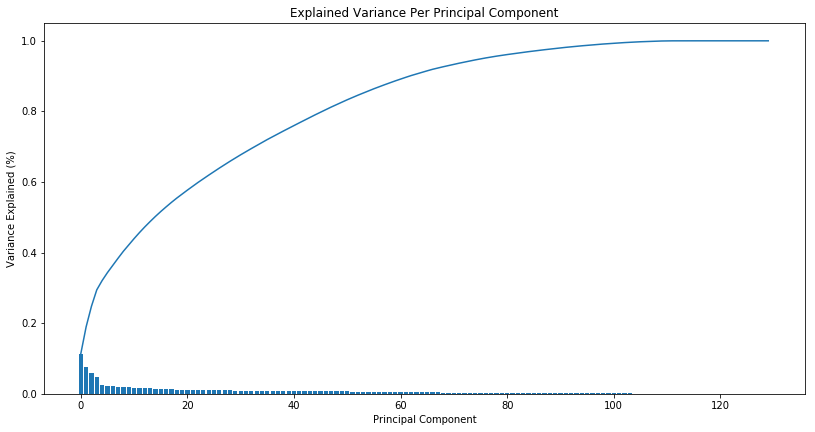

In [53]:
# Investigate the variance accounted for by each principal component.
components = len(pca.explained_variance_ratio_)
pc = np.arange(components)
values = pca.explained_variance_ratio_

plt.figure(figsize = (30, 15))
ax = plt.subplot(222)
cumulative_values = np.cumsum(values)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component')

ax.bar(pc, values)
ax.plot(pc, cumulative_values);    

In [54]:
# Checking total percent explained by number of principle component
total_explained = 0
pc = 0
for i in range(components):
        if total_explained >= .95:
            break
        else: 
            total_explained += values[i]
            pc += 1
            print(values[i])
print(str(round(total_explained*100,2))+'% explained by '+str(pc)+' principle components.')

0.11340668901
0.0762661553053
0.0582159750535
0.0466425291478
0.0261807951128
0.0226080475527
0.0206972054008
0.0202101863085
0.0197471877506
0.0179702234925
0.0176917113763
0.0169548640386
0.0160634242254
0.0151775780649
0.0145996089138
0.0138339321142
0.0131614330013
0.0127401252731
0.0121219449408
0.0115220007788
0.0111907936165
0.0110832032992
0.0107259768295
0.0103895559968
0.0102410127823
0.0101119581661
0.00992411861946
0.00972126365494
0.00952479048123
0.0092708392841
0.00913546953923
0.00894479509873
0.00866284102221
0.00861293691762
0.00851806090758
0.0084696974639
0.0080833913921
0.00799785936655
0.00789885736548
0.00783493515974
0.00773320938544
0.00770916591142
0.00769395638684
0.00766084000857
0.00754895404185
0.00738171582069
0.00730024333552
0.00723677108889
0.00695974770801
0.00694811809989
0.00670296453046
0.00650394185477
0.00637926673132
0.00618317236492
0.00607788052803
0.00599879773757
0.00581828521261
0.00554444787176
0.00549226522008
0.0053926022929
0.0052053418

In [55]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = pc)
azdias_pca = pca.fit_transform(azdias_ss)

### Discussion 2.2: Perform Dimensionality Reduction

Reviewing the varience explaned by the prinicple components in my scree plot I chose to find the number of components where at least 95% was accounted for, which ended up beeing at 77 components.  The first component accounts for just shy of 11.5% of the varience, from there dropping quickly with only three more components over 3%. Out of the original 130 components, 77 does not seem extream and covers most of the varience.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [56]:
# Function for finding weights of a given principle component
def weights_by_component(data, pca, component):
    df = pd.DataFrame(pca.components_[component])
    df.index = data.columns
    df.columns = ['PC_1']
    df = df.sort_values(by = ['PC_1'], ascending = False)
    return df

In [57]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
pc_1 = weights_by_component(azdias_ss, pca, 0)
print(pc_1)

                           PC_1
LP_STATUS_GROB_1.0        0.196
PLZ8_ANTG3                0.192
PLZ8_ANTG4                0.188
HH_EINKOMMEN_SCORE        0.186
ORTSGR_KLS9               0.169
EWDICHTE                  0.165
FINANZ_HAUSBAUER          0.154
HOUSEHOLD_WEALTH_0.0      0.153
HOUSEHOLD_LIFE_STAGE_0.0  0.143
KBA05_ANTG4               0.137
RESIDENTIAL_1.0           0.129
PLZ8_ANTG2                0.129
ARBEIT                    0.124
RURAL_1.0                 0.124
ANZ_HAUSHALTE_AKTIV       0.122
KBA05_ANTG3               0.118
CAMEO_DEUG_2015_9         0.116
RELAT_AB                  0.115
GREEN_AVANTGARDE_0        0.111
WEATHER_MAINSTREAM_0.0    0.111
FINANZTYP_1.0             0.102
FINANZ_SPARER             0.098
CAMEO_DEUG_2015_8         0.096
LP_FAMILIE_GROB_1.0       0.081
GEBAEUDETYP_3.0           0.072
SEMIO_PFLICHT             0.069
ZABEOTYP_5.0              0.069
SEMIO_REL                 0.064
SEMIO_RAT                 0.059
REGIOTYP                  0.054
W_KEIT_K

In [58]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc_2 = weights_by_component(azdias_ss, pca, 1)
print(pc_2)

                           PC_1
ALTERSKATEGORIE_GROB      0.250
FINANZ_VORSORGER          0.228
SEMIO_ERL                 0.224
ZABEOTYP_3.0              0.215
SEMIO_LUST                0.175
RETOURTYP_BK_S            0.151
CJT_GESAMTTYP_2.0         0.120
SEMIO_KRIT                0.112
FINANZTYP_2.0             0.106
W_KEIT_KIND_HH            0.104
SEMIO_KAEM                0.103
FINANZ_MINIMALIST         0.093
SHOPPER_TYP_3.0           0.091
ANREDE_KZ_2.0             0.091
FINANZTYP_5.0             0.083
FINANZ_HAUSBAUER          0.083
FINANZTYP_6.0             0.073
CJT_GESAMTTYP_1.0         0.072
SEMIO_DOM                 0.069
WOHNDAUER_2008            0.061
EWDICHTE                  0.049
ORTSGR_KLS9               0.049
PLZ8_ANTG4                0.046
PLZ8_ANTG3                0.046
HOUSEHOLD_LIFE_STAGE_4.0  0.043
LP_FAMILIE_GROB_1.0       0.040
ARBEIT                    0.040
RURAL_1.0                 0.039
KBA05_ANTG4               0.039
RELAT_AB                  0.036
REGION_2

In [59]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc_3 = weights_by_component(azdias_ss, pca, 2)
print(pc_3)


                           PC_1
ANREDE_KZ_1.0             0.313
SEMIO_VERT                0.291
SEMIO_SOZ                 0.223
SEMIO_FAM                 0.208
SEMIO_KULT                0.194
FINANZTYP_5.0             0.148
FINANZ_MINIMALIST         0.142
WEATHER_MAINSTREAM_1.0    0.106
GREEN_AVANTGARDE_1        0.106
ZABEOTYP_1.0              0.101
SHOPPER_TYP_0.0           0.100
RETOURTYP_BK_S            0.098
ORTSGR_KLS9               0.086
FINANZ_VORSORGER          0.086
EWDICHTE                  0.084
LP_STATUS_GROB_5.0        0.077
RURAL_1.0                 0.070
W_KEIT_KIND_HH            0.068
ALTERSKATEGORIE_GROB      0.066
PLZ8_ANTG4                0.061
PLZ8_ANTG3                0.061
SEMIO_LUST                0.058
RESIDENTIAL_1.0           0.056
SEMIO_REL                 0.054
SEMIO_MAT                 0.048
RELAT_AB                  0.047
ARBEIT                    0.047
ZABEOTYP_6.0              0.046
PLZ8_ANTG2                0.043
SHOPPER_TYP_1.0           0.043
GEBAEUDE

### Discussion 2.3: Interpret Principal Components

PC_1 is about income and family size, with LP_STATUS_GROB_1.0 (Prevalence of low income earners), HH_EINKOMMEN_SCORE (household net income) and PLZ8_ANTG3 & PLZ8_ANTG4 (prevalence of 6-10 and 10+ family homes respectively), ORTSGR_KLS9 (community size), and EWDICHTE (household density) being some of the furthest above zero.  In contrast strong negative features include PLZ8_ANTG1 & KBA05_ANTG1 (both about the prevalence of 1-2 family homes), KBA05_GBZ (number of buildings in the microcell area), and FINANZ_MINIMALIST (financial typology minimalist).  MOBI_REGIO (movement patterns) is the strongest negative feature, however based on dictionary definition it is hard to know how that fits in this these other extremes.

PC_2 is about personality type with the positive features focusing on less traditional including ALTERSKATEGORIE_GROB (an age estimate), FINANZ_VORSORGER (Be prepared financial type), SEMIO_ERL (Even oriented personality type), and ZABEOTYP_3.0 (Fair supplied energy).  The strong negative features are more traditional, featuring SEMIO_REL (Religious personality type), FINANZ_SPARER (Money Saver financial type), SEMIO_TRADV & SEMIO_PFLICHT (Traditional and dutiful personality types respectively), and FINANZ_UNAUFFAELLIGER (Inconspicuous financial type)

PC_3 is about gender and personality type with positive features focusing on ANREDE_KZ_1.0 (males), SEMIO_VERT (Dreamful personality),  SEMIO_SOZ (social minded personality), and SEMIO_FAM (Family minded personaility.  The strong negative features are ANREDE_KZ_2.0 (females), SEMIO_KAEM (combative personality), SEMIO_DOM (dominant-minded personality), and SEMIO_KRIT (critical minded personality).

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [60]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
kmeans = KMeans(n_clusters = 7)
model = kmeans.fit(azdias_pca[0:700])
    
    # compute the average within-cluster distances.
score = np.abs(model.score(azdias_pca[0:700]))
score    

65663.047355858667

28

Text(0.5,1,'Within Cluster Distance')

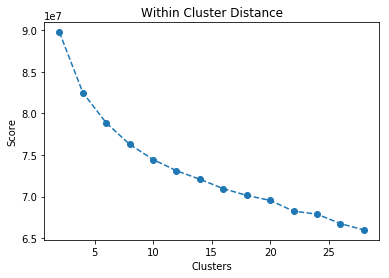

In [134]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
def kmeans_score(data, center):
    kmeans = KMeans(n_clusters = center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

scores = []
centers = list(range(2,30,2))

for center in centers:
    scores.append(kmeans_score(azdias_pca, center))
    clear_output(wait=True)
    display(center)
    
plt.plot(centers, scores, linestyle = '--', marker = 'o');
plt.xlabel('Clusters');
plt.ylabel('Score');
plt.title('Within Cluster Distance')

In [61]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 12)
model = kmeans.fit(azdias_pca)
labels = model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

In reviewing number of clusters I chose to check from two to thirty on the even amount of clusters and plot the scores.

I chose to segment the population at 12 clusters.  At that point the average distance decrease in the graph reduces less than previous cluster amounts (it is the elbow).

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [62]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [63]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers, customers_2 = clean_data(customers, cat_list)

# Column lists based on data type
numeric_col = columns_with_nans(customers, feat_info, 'numeric')
categorical_col = columns_with_nans(customers, feat_info, 'categorical')
ordinal_col = columns_with_nans(customers, feat_info, 'ordinal')
engineered_col = ['WEATHER_MAINSTREAM', 'REGION', 'HOUSEHOLD_WEALTH', 'HOUSEHOLD_LIFE_STAGE', 'RESIDENTIAL', 'RURAL']


'85/85 Columns processed'

In [64]:
# For those numeric columns with NaNs, replacing with median. 
imputer1 = Imputer(missing_values = np.nan, strategy = 'median', axis = 0)
customers[numeric_col] = imputer1.fit_transform(customers[numeric_col])

# For those categorical and ordinal columns with NaNs, replacing with most frequest answers.
imputer2 = Imputer(missing_values = np.nan, strategy = 'most_frequent', axis = 0)
#customers[categorical_col] = imputer2.fit_transform(customers[categorical_col])
customers[ordinal_col] = imputer2.fit_transform(customers[ordinal_col])
customers[engineered_col] = imputer2.fit_transform(customers[engineered_col])

# Category columns from feat_info, adding those engineered, and the separating those still in df for one hot encoding.
categorical_features = feat_info.loc[feat_info['type']=='categorical','attribute']
categorical_features = pd.concat([categorical_features,pd.Series(['WEATHER_MAINSTREAM','REGION','HOUSEHOLD_WEALTH','HOUSEHOLD_LIFE_STAGE','RESIDENTIAL','RURAL'])])
non_binary_columns = categorical_features[categorical_features.isin(list(customers.columns))]
non_binary_columns = non_binary_columns.tolist()

# One hot encoding for engineered columns.
customers = pd.get_dummies(customers, columns = non_binary_columns)

In [65]:
# Standard scaling
customers_ss = StandardScaler().fit_transform(customers)
customers_ss = pd.DataFrame(customers_ss)
customers_ss.columns = customers.columns

# PCA
customers_pca = pca.fit_transform(customers_ss)

# Clustering
labels_customers = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

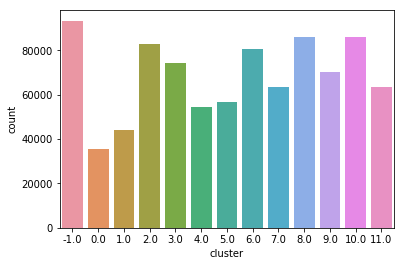

In [66]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Distribution of General Population
general_pop_labels = pd.DataFrame(labels)
general_pop_labels.columns =['cluster']
# Adding the rows with too many NaNs to the data as -1
gereral_pop_ex_labels = pd.DataFrame(-1*np.ones([azdias_2.shape[0],1]))
gereral_pop_ex_labels.columns = ['cluster']

labels_general = pd.concat([general_pop_labels,gereral_pop_ex_labels], axis = 0)

sns.countplot(x = 'cluster', data = labels_general)

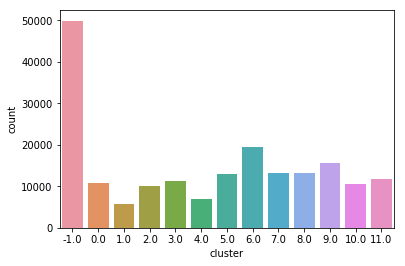

In [67]:
# Distribution of Customer Data
customer_labels = pd.DataFrame(labels_customers)
customer_labels.columns =['cluster']
# Adding the rows with too many NaNs to the data as -1
customer_ex_labels = pd.DataFrame(-1*np.ones([customers_2.shape[0],1]))
customer_ex_labels.columns = ['cluster']

labels_customer = pd.concat([customer_labels,customer_ex_labels], axis = 0)

sns.countplot(x = 'cluster', data = labels_customer)

In [68]:
compared = pd.DataFrame(labels_general['cluster'].value_counts())
compared = compared.rename(columns = {'cluster':'general'})
compared['customer'] = labels_customer['cluster'].value_counts() 
compared['cust_over_rep_gen'] =(compared['customer']/compared['customer'].sum())-(compared['general']/compared['general'].sum())

In [69]:
compared

,general,customer,cust_over_rep_gen
-1.000,93315,49939,0.156
10.000,86119,10664,-0.041
8.000,86110,13130,-0.028
2.000,82823,10150,-0.040
6.000,80706,19600,0.012
3.000,74369,11226,-0.025
9.000,70066,15597,0.003
7.000,63618,13188,-0.003
11.000,63593,11867,-0.009
5.000,56570,13094,0.005


In [77]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#Cluster 0 is slightly overrepresented in the customer data.
general_pop_labels.index = azdias_1.index
azdias_review = pd.concat([azdias_1,general_pop_labels], axis = 1)
cluster_0 = azdias_review.loc[azdias_review['cluster']==0,:]

In [140]:
# Printing the top response in columns with one answer other than 0 
# (An unknown field in categories) representing over 60% of answers
cluster_0 = cluster_0.iloc[: , 0:]
for a in cluster_0.columns:
    largest = 0
    total = 0
    i = 0
    i = cluster_0[a].value_counts().index[0]
    if i != 0.0:
        largest = cluster_0[a].value_counts().nlargest(1).sum()
        total = cluster_0[a].value_counts().sum()
        if largest/total >= .6:
            print(cluster_0[a].value_counts().nlargest(1))
    else:
        continue

7.000    21488
Name: SEMIO_DOM, dtype: int64
9.000    24173
Name: WOHNDAUER_2008, dtype: int64
1.000    21973
Name: ANZ_HAUSHALTE_AKTIV, dtype: int64
1992.000    22333
Name: MIN_GEBAEUDEJAHR, dtype: int64
1    33539
Name: ANREDE_KZ_2.0, dtype: int64
1    33498
Name: GREEN_AVANTGARDE_1, dtype: int64
1    25104
Name: GEBAEUDETYP_1.0, dtype: int64
1    33515
Name: OST_WEST_KZ_W, dtype: int64
1    33498
Name: WEATHER_MAINSTREAM_1.0, dtype: int64
1    22269
Name: REGION_2.0, dtype: int64
1    35087
Name: RESIDENTIAL_0.0, dtype: int64
1    29727
Name: RURAL_1.0, dtype: int64


In [136]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#Cluster 10 is the most underrepresented in the customer data.
azdias_review2 = pd.concat([azdias_1,general_pop_labels], axis = 1)
cluster_10 = azdias_review.loc[azdias_review['cluster']==10,:]

In [141]:
# Printing the top response in columns with one answer other than 0 
# (An unknown field in categories) representing over 60% of answers
cluster_10 = cluster_10.iloc[: , 0:]
for a in cluster_10.columns:
    largest = 0
    total = 0
    i = 0
    i = cluster_10[a].value_counts().index[0]
    if i != 0.0:
        largest = cluster_10[a].value_counts().nlargest(1).sum()
        total = cluster_10[a].value_counts().sum()
        if largest/total >= .6:
            print(cluster_10[a].value_counts().nlargest(1))
    else:
        continue

3.000    52490
Name: FINANZ_MINIMALIST, dtype: int64
5.000    61644
Name: RETOURTYP_BK_S, dtype: int64
1.000    53811
Name: ANZ_PERSONEN, dtype: int64
9.000    60947
Name: WOHNDAUER_2008, dtype: int64
1992.000    65180
Name: MIN_GEBAEUDEJAHR, dtype: int64
1.000    52007
Name: PLZ8_ANTG4, dtype: int64
1    85646
Name: ANREDE_KZ_1.0, dtype: int64
1    83164
Name: GREEN_AVANTGARDE_0, dtype: int64
1    54179
Name: LP_FAMILIE_GROB_1.0, dtype: int64
1    55523
Name: LP_STATUS_GROB_1.0, dtype: int64
1    53847
Name: VERS_TYP_2.0, dtype: int64
1    67668
Name: OST_WEST_KZ_W, dtype: int64
1    83164
Name: WEATHER_MAINSTREAM_0.0, dtype: int64
1    71704
Name: REGION_2.0, dtype: int64
1    82849
Name: RESIDENTIAL_0.0, dtype: int64
1    81531
Name: RURAL_1.0, dtype: int64
10    86119
Name: cluster, dtype: int64


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

The segments of the population that are mostly popular with the company in cluster 0 are females (ANREDE_KZ_2.0), in single household (ANZ_HAUSHALTE_AKTIV) residential buildings (RESIDENTIAL_0.0, GEBAEUDETYP_1.0) in the former west (OST_WEST_KZ_W) in non-rural areas(RURAL_1.0).  Typically they have been in this building for 10+ years (WOHNDAUER_2008).  The personality type predominantly has a low afinity to the dominant mindset (SEMIO_DOM) and as a youth were a member of the environmental sustainable group (GREEN_AVANTGARDE_1) and avantegarde was the dominant movement (WEATHER_MAINSTREAM_1.0).

The segments of the population that are relatively unpopular with the company in cluster 10 are males (ANREDE_KZ_1.0), single (LP_FAMILIE_GROB_1.0 & ANZ_PERSONEN), and low-income earners (LP_STATUS_GROB_1.0).  They live primarily in the former west (OST_WEST_KZ_W), in low-density (PLZ8_ANTG4), residential (RESIDENTIAL_0.0), non-rural (RURAL_1.0) areas. Typically they have been in this building for 10+ years (WOHNDAUER_2008).  As a youth Mainstream was the dominant movement (WEATHER_MAINSTREAM_0.0) and they were not members of the environmental sustainability group (GREEN_AVANTGARDE_0). The personality has low financial interest (FINANZ_MINIMALIST), rarely returns items as a consumer (RETOURTYP_BK_S), and their insurance type is individualistic, accepting risk (VERS_TYP_2.0).

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.